In [1]:
import getopt
import sys
import pandas as pd
from pfs.lam.detAnalysis import *
import time
import numpy as np

In [2]:
from pfs.lam.opdb import *


In [3]:
from pfs.lam.fileHandling import *
from pfs.lam.detFocusAnalysis import *


import os
import lsst.daf.persistence as dafPersist
import re
from astropy.modeling import models, fitting
from astropy.stats import gaussian_sigma_to_fwhm

In [4]:
def VisitImageQualityToCsv(visit, \
                           peak_list, roi_size, com=True, doBck=True, EE=[3,5], doFit=True, doLSF=False,\
                           cam=None, repo="cluster",rerun="sm1-dither", cluster=False, doPlot=False,\
                           doSep=False, mask_size=50, threshold= 50, subpix = 5 , maxPeakDist=80,\
                           maxPeakFlux=40000, minPeakFlux=2000,\
                          csv_path = "", drpImage=None, experimentId = None, doPrint=False):
    if drpImage is None:
        experimentId = Logbook.visitExperimentId(visit=visit)
        
        doRaise = True
        try:
            filepath, date = getvisitfilepath(visit, rerun, None, cam, repo, cluster=cluster)
            visitfilepath = filepath
        except IOError:
            if doRaise:
                raise
    else :
        filepath = drpImage[0]
        visitfilepath = drpImage[1]
        visit = drpImage[2]
        try:
            #experimentId = Logbook.visitExperimentId(visit=visit)
            experimentId = get_Visit_Set_Id(visit)
        except:
            experimentId = np.nan
            print("Unable to get experimentId from logbook")

    data = getImageQuality(filepath, peak_list, roi_size=roi_size, EE=EE, com=com, doPlot=doPlot, doBck=doBck, doFit=doFit, doLSF=doLSF)
    if doSep:
        dsep = getImageEncerclEnergy(filepath, peak_list, roi_size=roi_size, EE=EE,\
        mask_size=mask_size, threshold= threshold, subpix = subpix ,\
        maxPeakDist=maxPeakDist, maxPeakFlux=maxPeakFlux, minPeakFlux=minPeakFlux,\
        doPlot=doPlot, doBck=doBck)
        dsep = dsep.add_prefix("sep_")
        dsep = dsep.rename(columns={'sep_peak': 'peak','sep_fiber': 'fiber'})
        data = data.merge(dsep, on=["peak","fiber"]) 
    __, fname = os.path.split(visitfilepath)

    data["filename"] = fname
    data["visit"] = visit

#    data["peaklist"] = peak_list        

#    data["motor1"] = np.float(getFitsKey(visitfilepath, 'W_XCU_MOTOR1_MICRONS'))
#    data["motor2"] = np.float(getFitsKey(visitfilepath, 'W_XCU_MOTOR2_MICRONS'))
#    data["motor3"] = np.float(getFitsKey(visitfilepath, 'W_XCU_MOTOR3_MICRONS'))
    data["xm1pos"] = np.float(getFitsKey(visitfilepath, 'W_XM1POS'))
    data["xm2pos"] = np.float(getFitsKey(visitfilepath, 'W_XM2POS'))
    data["xm3pos"] = np.float(getFitsKey(visitfilepath, 'W_XM3POS'))
    data["motor1"] = data["xm1pos"] 
    data["motor2"] = data["xm2pos"]
    data["motor3"] = data["xm3pos"]   
    
    
    fcax = np.float(getFitsKey(visitfilepath, 'W_ENFCAX', doRaise=False))
    fcay = np.float(getFitsKey(visitfilepath, 'W_ENFCAY', doRaise=False))
    fcaz = np.float(getFitsKey(visitfilepath, 'W_ENFCAZ', doRaise=False))

    # OneChannel back compatiblity
    fcax = np.float(getFitsKey(visitfilepath, 'HIERARCH W_FCA_FOCUS', doRaise=False)) if np.isnan(fcax) else fcax
    data['fcaFocus'] = np.nan #cax
    data['fcaY'] = np.nan #fcay
    data['fcaZ'] = np.nan #fcaz

#    feeTemp = np.float(getFitsKey(visitfilepath, 'temps.FEE'))
#    feeTemp = np.float(getFitsKey(visitfilepath, 'HIERARCH temps.FEE', doRaise=False)) if np.isnan(feeTemp) else feeTemp

#    data['feeTemp'] = feeTemp
#    ccdTemp = np.float(getFitsKey(visitfilepath, 'temps.CCD0'))
#    ccdTemp = np.float(getFitsKey(visitfilepath, 'HIERARCH temps.CCD0', doRaise=False)) if np.isnan(ccdTemp) else ccdTemp
#    data['ccdTemp'] = ccdTemp
    ccdTemp = np.float(getFitsKey(visitfilepath, 'W_XTDET1', doRaise=False))
    data['ccdTemp'] = ccdTemp
    detBoxTemp = np.float(getFitsKey(visitfilepath, 'W_XTDBOX', doRaise=False))
    data['detBoxTemp'] = detBoxTemp

    data['cam'] = cam
    data['obsdate'] = getFitsKey(visitfilepath, 'DATE-AVG')
    data['experimentId'] = experimentId

    now = datetime.now() # current date and time\n",
    date_time = now.strftime("%Y%m%dT%Hh%M")

    csvName = f"Imquality_{cam}_Exp{experimentId}_{visit}_{date_time}.csv"
    if not os.path.exists(csv_path):
        os.makedirs(csv_path)
    data.to_csv(csv_path+csvName)
    if doPrint:
        print(csv_path+csvName)

    return data

In [ ]:
experimentId = 124
cam = "b2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_Neon_3peaks_B2_Dec2020.csv"


In [ ]:
experimentId = 125
cam = "b2"
rerun = "defocus" #"dcb2"

peaklist = "../SM2-defocus/Imqual_LAM_peaklist_DCB2-notfinal.csv"

In [ ]:
experimentId = 136
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 152
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 153
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 154
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 156
cam = "b2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_Neon_3peaks_B2_Dec2020.csv"


In [ ]:
experimentId = 157
cam = "b2"
rerun = "defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_3peaks_B2_Dec2020.csv"



In [ ]:
experimentId = 171
cam = "b2"
rerun = "ginga" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_B2_Jan2020_WS_slit.csv"



In [ ]:
experimentId = 190
cam = "r3"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv"



In [ ]:
experimentId = 191
cam = "r3"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv"



In [ ]:
experimentId = 173
cam = "r2"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_R2_Jan2020_WS_slit.csv"



In [ ]:
experimentId = 202
cam = "b3"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_B3_WS_slit.csv"



In [ ]:
experimentId = 203
cam = "b3"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_B3_WS_slit.csv"



In [5]:
experimentId = 204
cam = "b3"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_B3_WS_slit.csv"



In [6]:
visitStart, visitEnd = getVisitRange(experimentId)

In [7]:
print(visitStart, visitEnd)

24369 24389


In [8]:
drpPath = "/drp"
repo = "sps"
basePath = '/drp/analysis/sm2/'
arm = cam[0]


In [9]:
visit = int(visitStart)

In [10]:
print(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")

butler = dafPersist.Butler(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")
rbutler = dafPersist.Butler(f"{drpPath}/{repo}/")
rbutler.getKeys('raw')
lamps = rbutler.queryMetadata('raw', ['lamps'], visit=visit, arm=arm) 
print(f"lamps used: {lamps}")
calExp = butler.get("calexp", visit=visit, arm=cam[0])

peaks = pd.read_csv(peaklist)
selected_peaks = peaks[peaks.arm == arm]
selected_peaks = selected_peaks[(selected_peaks.element.str.contains('|'.join(re.findall('[A-Z][^A-Z]*', "".join(lamps)))))]

/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']


#Fiber= 4 and #wavelength= 2


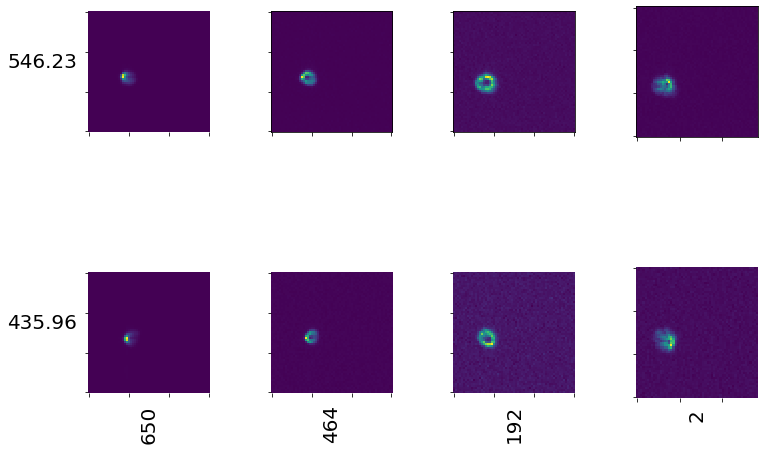

In [11]:
plotRoiPeak(calExp.image.array, selected_peaks, raw=True, roi_size=60)

In [ ]:
    # define defaut parameters
    roi_size = 60
    com = True  # Center Of Mass
    doBck = True
    head = 0
    tail = 0
    criteria = 'EE5'
    verbose = True
    doPrint = False
    arm = cam[0]
    
    drpPath = "/drp"
    repo = "sps"
    basePath = '/drp/analysis/sm2/'
    extra = ''
    
    for visit in range(visitStart, visitEnd+1):

        #now = datetime.now() # current date and time\n",
        #date_time = now.strftime("%Y%m%dT%Hh%M")
        #csvPath = basePath+"Exp"+str(experimentId)+"/"+rerun+"_roi"+str(roi_size)+"/doBck"+str(doBck)+"/"+date_time+"/"
        csvPath = basePath+"Exp"+str(experimentId)+"/"+rerun+"_roi"+str(roi_size)+"/doBck"+str(doBck)+"/"

        print(csvPath)

    #    peakPath ="/home/fmadec/dev/ait-notebook/optical/input/"
    #    peaklist = peakPath+peaklist
    #    peaklist = "/drp/cluster/devel/ait-notebook/fmadec/Subaru/SM1/selectLines/Imqual_LAM_peaklist_2020July.csv"
#        peaklist = "SM2_peak_engineering_20201210.csv"        
#        peaklist = "SM2_peak_dcb2_20201211.csv"
#        peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"

#        peaklist = "SM2_peak_dcb2_neon_20201211.csv"


    #   VisitImageQualityToCsv(visit, peaklist, roi_size, cam=cam, \
    #                          repo="sm1",rerun="ginga",  cluster=True, \
    #                          com=True, doBck=True, EE=[3,5], doFit=True, doLSF=False,
    #                          csv_path = outpath)

        print(f'Start visit {visit} of {cam} with {peaklist}')
        print(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")

        butler = dafPersist.Butler(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")
        rbutler = dafPersist.Butler(f"{drpPath}/{repo}/")
        rbutler.getKeys('raw')
        lamps = rbutler.queryMetadata('raw', ['lamps'], visit=visit, arm=arm) 
        print(f"lamps used: {lamps}")
        calExp = butler.get("calexp", visit=visit, arm=cam[0])

        peaks = pd.read_csv(peaklist)
        selected_peaks = peaks[peaks.arm == arm]
        selected_peaks = selected_peaks[(selected_peaks.element.str.contains('|'.join(re.findall('[A-Z][^A-Z]*', "".join(lamps)))))]
 #       selected_peaks = peaksdef plotRoiPeak(image, peak_list, roi_size=20, raw=False, scale=True, verbose=False, savePlotFile=False):

        print(selected_peaks.element.unique())
        visit = int(visit)
        calExp = butler.get("calexp", visit=visit, arm=cam[0])
        calexfilePath = butler.getUri("calexp", visit=visit, arm=cam[0])
        if verbose:
            print(calexfilePath)

        data = VisitImageQualityToCsv(visit, selected_peaks, roi_size,\
                               drpImage=[ calExp.image.array, calexfilePath, visit],\
                               com=com, doBck=doBck, EE=[3,5,20], doFit=True, doLSF=False,\
                               cam=cam, repo=None,rerun=None, cluster=False, doPlot=False,\
                               doSep=False, mask_size=20, threshold= 50, subpix = 5 , maxPeakDist=80,\
                               maxPeakFlux=40000, minPeakFlux=2000,\
                               csv_path = csvPath, experimentId=experimentId, doPrint=verbose)

/drp/analysis/sm2/Exp204/ws_slit_roi60/doBckTrue/
Start visit 24369 of b3 with Imqual_LAM_peaklist_DEBUG_B3_WS_slit.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Hg']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-03-08/v024369/calExp-LA024369b3.fits
/drp/analysis/sm2/Exp204/ws_slit_roi60/doBckTrue/Imquality_b3_Exp204_24369_20210309T01h09.csv
/drp/analysis/sm2/Exp204/ws_slit_roi60/doBckTrue/
Start visit 24370 of b3 with Imqual_LAM_peaklist_DEBUG_B3_WS_slit.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Hg']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-03-08/v024370/calExp-LA024370b3.fits
/drp/analysis/sm2/Exp204/ws_slit_roi60/doBckTrue/Imquality_b3_Exp204_24370_20210309T01h09.csv
/drp/analysis/sm2/Exp204/ws_slit_roi60/doBckTrue/
Start visit 24371 of b3 with Imqual_LAM_peaklist_DEBUG_B3_WS_slit.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Hg']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-03-08/v024371/calExp-LA024371b3.fits
/drp/analysis/sm2/Exp204/ws_slit

In [ ]:
data.wavelength